In [1]:
%autosave 30
%matplotlib inline
# for tips: https://www.kaggle.com/prakharprasad/facerecognition-facenet-cnnclassifier

Autosaving every 30 seconds


# Basics

**FaceNet**
* FaceNet is a face recognition system that was described by Florian Schroff, et al. at Google in their 2015 paper titled “FaceNet: A Unified Embedding for Face Recognition and Clustering.”
* It is a system that, given a picture of a face, will extract high-quality features from the face and predict a 128 element vector representation these features, called a face embedding.

## Import liberaries

In [2]:
import os
import sys
import random
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Python Imaging Library (PIL) by Fredrik Lundh
from PIL import Image  
from keras.models import load_model


# For classification of different faces, SVC
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.metrics import accuracy_score

from platform import python_version
print(f"python version: {python_version()}")

python version: 3.7.12


## MCTNN
* Multi-task Cascaded Convolutional Networks (MTCNN) is a framework developed by David Sandberg as a solution for both face detection and face alignment. 
* The process consists of three stages of convolutional networks that are able to recognize faces and landmark location such as eyes, nose, and mouth.

In [3]:
# create the mtcnn detector using default weights
# Multi-task Cascaded Convolutional Networks (MTCNN)
from mtcnn.mtcnn import MTCNN
detector = MTCNN()
#print(mtcnn.__version__)

2021-11-30 12:56:33.207005: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Saved Facenet Model

In [4]:
## Get the general path for saved model
path_saved_model=os.environ.get('DirForSavedModel')+'/face_recognisition/'
facenet_model=load_model(path_saved_model+'facenet_keras.h5')

print(f"Input: {facenet_model.inputs}")
print(f"Output: {facenet_model.outputs}")

Input: [<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]
Output: [<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Bottleneck_BatchNorm')>]


# Download Dataset

## Download Kaggle dataset
- this does not work, since the API I use is meant for downloading competition dataset, and this dataset is owned privately by someone called dansbecker.

In [5]:
#sys.path.append(os.environ.get('DirForPoolScripts'))
#from download_kaggle_data import upload_kaggle_dataset

In [6]:
#base_dir = os.environ.get('DirForSavedModel')
#dataset_name = 'dansbecker/5-celebrity-faces-dataset'
#facenet_model = 'facenet-keras'
#upload_kaggle_dataset(base_dir_name=base_dir, kaggle_dataset_name=facenet_model)

# Data Preprocessing

## Define directory structure

In [7]:
base_dir = os.environ.get('DirForLocalDataset')+'/6-celebrity-faces-dataset/'

sub_dir_name = [dirs for dirs in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, dirs))]
print(f"sub_directories are {sub_dir_name}")

base_dir_train  = os.path.join(base_dir, sub_dir_name[0]+'/')
base_dir_val    = os.path.join(base_dir, sub_dir_name[1]+'/')

sub_sub_dir = os.listdir(os.path.join(base_dir,base_dir_train))

base_dir_ben     = os.path.join(base_dir_train, ' '.join([str(fn) for fn in sub_sub_dir if 'ben' in fn])+'/')
base_dir_madonna = os.path.join(base_dir_train, ' '.join([str(fn) for fn in sub_sub_dir if 'madonna' in fn])+'/')
base_dir_elton   = os.path.join(base_dir_train, ' '.join([str(fn) for fn in sub_sub_dir if 'elton' in fn])+'/')
base_dir_mindy   = os.path.join(base_dir_train, ' '.join([str(fn) for fn in sub_sub_dir if 'mindy' in fn])+'/')
base_dir_jerry   = os.path.join(base_dir_train, ' '.join([str(fn) for fn in sub_sub_dir if 'jerry' in fn])+'/')
base_dir_leo     = os.path.join(base_dir_train, ' '.join([str(fn) for fn in sub_sub_dir if 'leo' in fn])+'/')

sub_directories are ['train', 'val']


In [8]:
## Remove the nuisance files ".DS_Store"
for dirs in sub_sub_dir:
    if not os.path.isdir(os.path.join(base_dir_train, dirs)):
        continue
        
    for sub_dir in os.listdir(os.path.join(base_dir_train, dirs)):
        if ".DS_Store" in sub_dir:
            os.remove(os.path.join(base_dir_train, dirs, sub_dir))
        else:
            print("There is none nuisance files to be removed!")

There is none nuisance files to be removed!
There is none nuisance files to be removed!
There is none nuisance files to be removed!
There is none nuisance files to be removed!
There is none nuisance files to be removed!
There is none nuisance files to be removed!
There is none nuisance files to be removed!
There is none nuisance files to be removed!
There is none nuisance files to be removed!
There is none nuisance files to be removed!
There is none nuisance files to be removed!
There is none nuisance files to be removed!
There is none nuisance files to be removed!
There is none nuisance files to be removed!
There is none nuisance files to be removed!
There is none nuisance files to be removed!
There is none nuisance files to be removed!
There is none nuisance files to be removed!
There is none nuisance files to be removed!
There is none nuisance files to be removed!
There is none nuisance files to be removed!
There is none nuisance files to be removed!
There is none nuisance files to 

## Draw frequency plot

In [9]:
def draw_name_frequency_plot(directory):
    
    labels = [subdir.replace("_", " ").title() for subdir in os.listdir(directory) if os.path.isdir(os.path.join(directory,subdir))]
    label_count = [len(os.listdir(os.path.join(directory, subdir))) for subdir in os.listdir(directory) if os.path.isdir(os.path.join(directory,subdir)) ]
            
    c = ['green', 'yellow', 'cyan', 'gray', 'orange','olive','sandybrown','plum']
    plt.rcParams["figure.figsize"] = (16,5)
    plt.bar(labels, label_count, color=c)
    plt.ylabel('count', fontsize=20)
    plt.xticks(fontsize= 14)
    plt.yticks(fontsize= 14)
    plt.grid(True, linewidth= 1, linestyle="--")
    plt.show()  

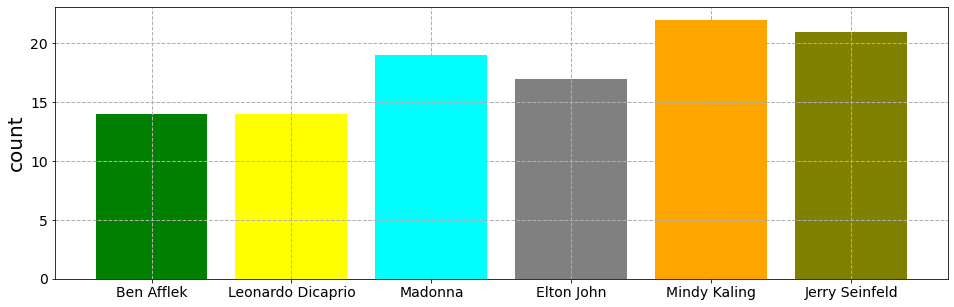

In [10]:
draw_name_frequency_plot(base_dir_train)

## Extract facial features
´detector=MTCNN()´
* The detector returns a list of JSON objects. Each JSON object contains three main keys: 'box', 'confidence' and 'keypoints':
    - The bounding box is formatted as [x, y, width, height] under the key 'box'.
    - The confidence is the probability for a bounding box to be matching a face.
    - The keypoints are formatted into a JSON object with the keys 'left_eye', 'right_eye', 'nose', 'mouth_left', 'mouth_right'. Each keypoint is identified by a pixel position (x, y).

In [11]:
def draw_face_boundaries(image, feature_coordinate):
    filename = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    bounding_box = feature_coordinate[0]['box']
    keypoints = feature_coordinate[0]['keypoints']
    cv2.rectangle(filename,
                  (bounding_box[0], bounding_box[1]),
                  (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
                  (0,155,255),
                  2)
    cv2.circle(filename,(keypoints['left_eye']),   2, (0,155,255), 2)
    cv2.circle(filename,(keypoints['right_eye']),  2, (0,155,255), 2)
    cv2.circle(filename,(keypoints['nose']),       2, (0,155,255), 2)
    cv2.circle(filename,(keypoints['mouth_left']), 2, (0,155,255), 2)
    cv2.circle(filename,(keypoints['mouth_right']),2, (0,155,255), 2)
    #cv2.imwrite(image, cv2.cvtColor(filename, cv2.COLOR_RGB2BGR))
    plt.imshow(filename)

In [12]:
def extract_face(filename,required_size=(160, 160), print_features=False, show_features=False): 
    
    # pre-processing on file image
    image = Image.open(filename)
    image = image.convert('RGB')
    pixels = np.asarray(image)

    face_coordinates = detector.detect_faces(pixels)
    
    if show_features:
        draw_face_boundaries(filename, face_coordinates)
    if print_features:
        print(f"> Extracted features: \n {face_coordinates}")

    x1, y1, width, height = face_coordinates[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    
    # extract the face
    face = pixels[y1:y2, x1:x2]
    
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    
    return face_array

2021-11-30 12:57:02.683840: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


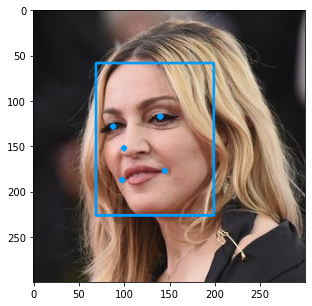

In [13]:
# load the photo and extract the face
pixels = extract_face(base_dir_madonna + os.listdir(base_dir_madonna)[11],  show_features=True)
#plt.imshow(pixels)

In [14]:
def extract_all_faces(directory, show_points=False, show_print=False):
    nrows = 4
    ncols = round(len(os.listdir(directory)) / nrows) + 1
    
    for count, filename in enumerate(os.listdir(directory)):
        path = directory + "/" + filename
        face = extract_face(path, show_features=show_points, print_features=show_print)
        plt.subplot(nrows, ncols, count+1)
        plt.axis('off')
        plt.imshow(face)
    plt.show()

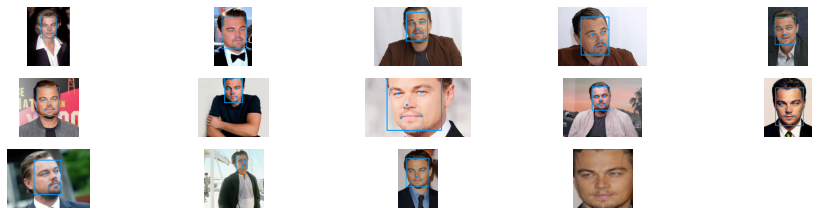

In [15]:
extract_all_faces(directory=base_dir_leo, show_points=True)

## Prepare dataset

In [16]:
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
    X, y = [],[] 

    for subdir in os.listdir(directory):
        path = directory + subdir + '/'

        # skip directories
        if not os.path.isdir(path):
            continue

        faces = [extract_face(path+subpath) for subpath in os.listdir(path)]        
        labels = [subdir for _ in range(len(faces))]
        
        print(f'>loaded {len(faces)} examples for class: {subdir}')
        
        X.extend(faces)
        y.extend(labels)
        
    return np.asarray(X), np.asarray(y)

In [17]:
# load train dataset
trainX, trainy = load_dataset(base_dir_train)
testX,   testy = load_dataset(base_dir_val)
print(f"train=> X.shape: {trainX.shape}, y.shape: {trainy.shape}")
print(f"test=> X.shape: {testX.shape}, y.shape: {testy.shape}")

>loaded 14 examples for class: ben_afflek
>loaded 14 examples for class: leonardo_dicaprio
>loaded 19 examples for class: madonna
>loaded 17 examples for class: elton_john
>loaded 22 examples for class: mindy_kaling
>loaded 21 examples for class: jerry_seinfeld
>loaded 5 examples for class: ben_afflek
>loaded 3 examples for class: leonardo_dicaprio
>loaded 5 examples for class: madonna
>loaded 5 examples for class: elton_john
>loaded 5 examples for class: mindy_kaling
>loaded 5 examples for class: jerry_seinfeld
train=> X.shape: (107, 160, 160, 3), y.shape: (107,)
test=> X.shape: (28, 160, 160, 3), y.shape: (28,)


# Modelling

## Face Embedding via Facenet

In [22]:
def get_128vectorEmbedding_singleImage(model, face_pixels):
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    
    # normalize pixel values across channels
    face_pixels_normalized = (face_pixels - face_pixels.mean()) / face_pixels.std()
    
    # transform face into one sample
    samples = np.expand_dims(face_pixels_normalized, axis=0)
    
    # make prediction to get embedding
    yhat = model.predict(samples) # returns ndarrary:(1,128)
    
    return yhat[0]

In [23]:
# get the face embedding for whole dataset, train/text
def get_embedding_dataset(model, train_X, test_X):
    
    embTrain_X = [get_128vectorEmbedding_singleImage(model, face_pixels) for face_pixels in train_X]
    embTest_X  = [get_128vectorEmbedding_singleImage(model, face_pixels) for face_pixels in test_X]
    
    print(f'embTrain_X shape: {np.asarray(embTrain_X).shape}, embText_X shape: {np.asarray(embTest_X).shape}')
    
    return np.asarray(embTrain_X), np.asarray(embTest_X)

In [24]:
embTrain_X, embTest_X = get_embedding_dataset(model=facenet_model, train_X=trainX, test_X=testX)

embTrain_X shape: (107, 128), embText_X shape: (28, 128)


## Triplet loss

In [18]:
def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.
    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    """
    # Check that i, j and k are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)
    i_not_equal_j = tf.expand_dims(indices_not_equal, 2)
    i_not_equal_k = tf.expand_dims(indices_not_equal, 1)
    j_not_equal_k = tf.expand_dims(indices_not_equal, 0)

    distinct_indices = tf.logical_and(tf.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)


    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    i_equal_j = tf.expand_dims(label_equal, 2)
    i_equal_k = tf.expand_dims(label_equal, 1)

    valid_labels = tf.logical_and(i_equal_j, tf.logical_not(i_equal_k))

    # Combine the two masks
    mask = tf.logical_and(distinct_indices, valid_labels)

    return mask

In [19]:
def _pairwise_distances(embeddings, squared=False):
    """Compute the 2D matrix of distances between all the embeddings.

    Args:
        embeddings: tensor of shape (batch_size, embed_dim)
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        pairwise_distances: tensor of shape (batch_size, batch_size)
    """
    # Get the dot product between all embeddings
    # shape (batch_size, batch_size)
    dot_product = tf.matmul(embeddings, tf.transpose(embeddings))

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    # square_norm = tf.diag_part(dot_product)
    square_norm =tf.linalg.diag_part(dot_product)

    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = tf.expand_dims(square_norm, 0) - 2.0 * dot_product + tf.expand_dims(square_norm, 1)

    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = tf.maximum(distances, 0.0)

    if not squared:
        # Because the gradient of sqrt is infinite when distances == 0.0 (ex: on the diagonal)
        # we need to add a small epsilon where distances == 0.0
        mask = tf.cast(tf.equal(distances, 0.0), dtype=tf.float32)
        #mask = tf.to_float(tf.equal(distances, 0.0))
        distances = distances + mask * 1e-16

        distances = tf.sqrt(distances)

        # Correct the epsilon added: set the distances on the mask to be exactly 0.0
        distances = distances * (1.0 - mask)

    return distances

## SVM Classifier

In [27]:
def normalize_vectors(vectors):
    """ normalize input vectors """ 
    normalizer = Normalizer(norm='l2')
    vectors = normalizer.transform(vectors)

    return vectors

In [28]:
def labels_encoder(labels):
    """provide one hot encoding of incoming labels"""
    out_encoder = LabelEncoder()
    out_encoder.fit(labels)
    labels = out_encoder.transform(labels)
    return out_encoder, labels

In [29]:
def svm_classifier(train_x_embedding, train_y, test_x_embedding, test_y):

    # normalize input vectors
    train_x_norm_embedding   = normalize_vectors(train_x_embedding)
    test_x_norm_embedding    = normalize_vectors(test_x_embedding)

    # label encode targets 
    out_encoder, train_y_class = labels_encoder(train_y)
    out_encoder, test_y_class  = labels_encoder(test_y)

    # fit model
    model       = SVC(kernel='linear', probability=True)
    model.fit(train_x_norm_embedding, train_y_class)
    
    yhat_train  = model.predict(train_x_norm_embedding)
    yhat_test   = model.predict(test_x_norm_embedding)
    
    score_train = accuracy_score(train_y_class, yhat_train)
    score_test  = accuracy_score(test_y_class, yhat_test)
    print(f'Accuracy: train={score_train*100}, test={score_test*100}')
    
    return model

In [30]:
svm_model= svm_classifier(embTrain_X, trainy, embTest_X, testy)

Accuracy: train=100.0, test=100.0


## Save SVM model

In [31]:
## save the model
try:
    import dill as pickle
except ImportError:
    import pickle
with open(path_saved_model+'svm_classifie_6_celebraties.pkl','wb') as file_pi:
    pickle.dump(svm_model, file_pi)

In [ ]:
# load the model
#model_test = pickle.load(open(path_saved_model+'svm_classifie_5_celebraties.pkl', "rb"))

# use model to predict
#y_pred = model.predict(X_input)

In [ ]:
#test_x_norm_embedding, test_y_class, label_encoder, svm_model= svm_classifier(embTrain_X, trainy, embTest_X, testy)

# Testing

## Test random testimages

In [32]:
def random_testing_test_data(test_data, test_label, embedding_model, classification_model) :
    # test model on a random example from the test dataset
    selection          = random.choice([i for i in range(test_data.shape[0])])

    random_face_pixels = get_128vectorEmbedding_singleImage(embedding_model, test_data[selection])
    random_face_pixels = np.expand_dims(random_face_pixels, axis=0)
    random_face_emb    = normalize_vectors(random_face_pixels)

    label_encoder, test_y_class  = labels_encoder(test_label)
    random_face_class            = test_y_class[selection]
    random_face_name             = label_encoder.inverse_transform([random_face_class])

    # prediction for the face
    yhat_class = classification_model.predict(random_face_emb)
    yhat_prob  = classification_model.predict_proba(random_face_emb)

    # get name
    class_index       = yhat_class[0]
    class_probability = yhat_prob[0,class_index] * 100
    predict_names     = label_encoder.inverse_transform(yhat_class)
    print(f'Predicted: {predict_names[0].replace("_"," ").title()} confidence:({round(class_probability,2)})')
    print(f'Expected: {random_face_name[0].replace("_"," ").title()}')

    # ploting
    plt.imshow(test_data[selection])
    title = f'{predict_names[0].replace("_"," ").title()} ({round(class_probability,2)})'
    plt.title(title)
    plt.show()

Predicted: Madonna confidence:(69.58)
Expected: Madonna


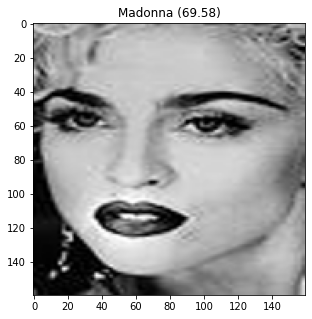

In [49]:
random_testing_test_data(testX, testy, facenet_model, svm_model)

## Externally uploaded face

In [ ]:
# load the model
path_saved_model=os.environ.get('DirForSavedModel')+'/face_recognisition/'
svm_model = pickle.load(open(path_saved_model+'svm_classifie_8_celebraties.pkl', "rb"))
facenet_model=load_model(path_saved_model+'facenet_keras.h5')

In [ ]:
def extract_labels(directory):
    y = []
    for subdir in os.listdir(directory):
        path = directory + subdir + '/'
        if not os.path.isdir(path):
            continue
        range_dir = [subpath for subpath in os.listdir(path)]
        labels = [subdir for _ in range(len(range_dir))]
        y.extend(labels)
    return np.asarray(y)

def load_labels():
    base_dir = os.environ.get('DirForImages')+'/5-celebrity-faces-dataset/'
    dataset_path = os.path.join(base_dir, 'train/')
    labels = extract_labels(dataset_path)
    return labels

labels = load_labels()

In [ ]:
def externaly_uploaded_face(image, test_label, embedding_model, classifiation_model, threshold=80):
    image_pixels = extract_face(image, show_features=False)
    emb_image    = get_128vectorEmbedding_singleImage(embedding_model, image_pixels)
    print(emb_image)

    # prediction for the face
    samples_image = np.expand_dims(emb_image, axis=0)
    yhat_class    = classifiation_model.predict(samples_image)
    yhat_prob     = classifiation_model.predict_proba(samples_image)

    # setup encoder for test images    
    label_encoder, test_y_class  = labels_encoder(test_label)

    # get name
    class_index       = yhat_class[0]
    class_probability = yhat_prob[0,class_index] * 100
    
    if class_probability >= threshold:
        predicted_name = label_encoder.inverse_transform(yhat_class)[0]
    else:
        predicted_name = 'Unknown'
    
    plt.imshow(image_pixels)
    title = f'{predicted_name.replace("_"," ").title()} ({round(class_probability,2)})'
    plt.title(title)
    print(f'Predicted: {predicted_name.replace("_"," ").title()} confidence:({round(class_probability,2)})')
    plt.show()

In [ ]:
os.listdir(base_dir_data)

In [ ]:
image= os.listdir(base_dir_data)[0]
image_path=os.path.join(base_dir_data, image)
externaly_uploaded_face(image_path, labels, facenet_model, svm_model, threshold=80)